# Python Driving License: data elaboration of a Corrosion Test

Electrochemical behaviour and corrosion resistance of metals can be evaluated by means of simple and standardized tests.

The sample to be analized is placed in contact with a salinated solution together with a reference electrode (in this case a saturated Calomel) and a counter electrode (usually a Pt mesh). To perform an accelerated corrosion test, one has to use a potentiostat which is in charge of applied a specific voltage (potential) and record the current output. A Linear Sweep Voltammetry test is conducted in a potential potential interval of 500 mV (centered in the Open Circuit Potential of the system) with a scan rate of 10 mV/minute.

The aim of this script is to use the resulting data from potentiostat, manipulate them and perform calculations to obtain the relevant values of interest related to the corrosion behaviour of a metal. 

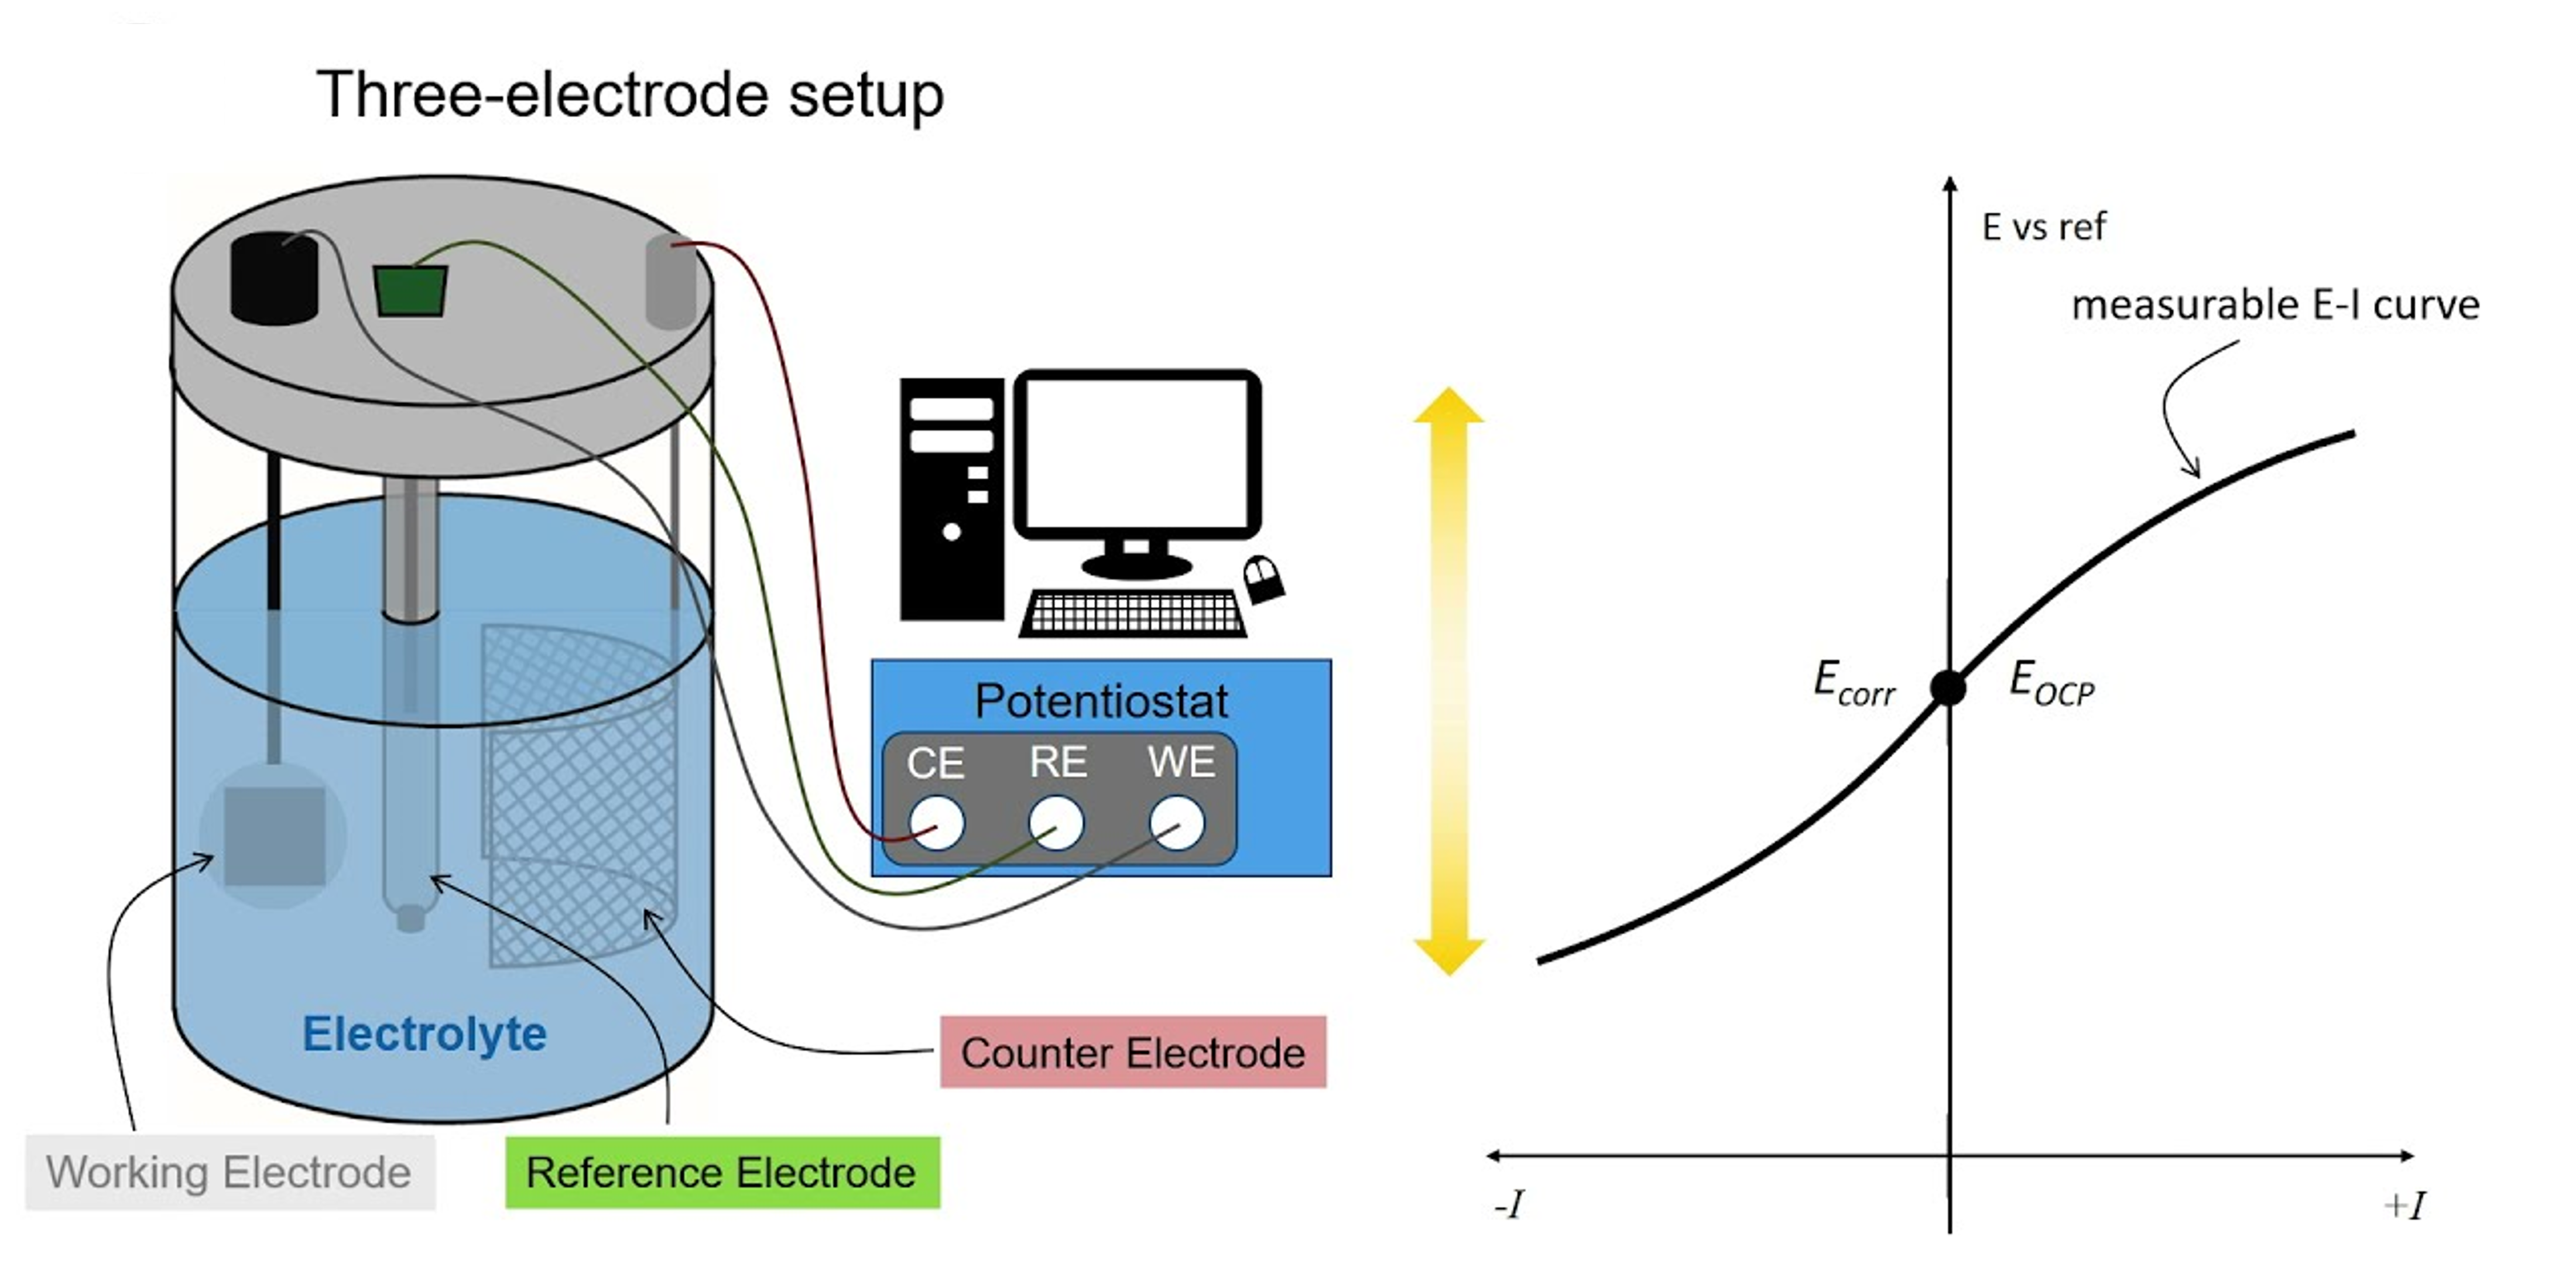

In [9]:
# Data import, definition of parameters and manipulation

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import time

start_time = time.time() # Start the timer

column_indices = [1, 2]

df = pd.read_csv("G:\Il mio Drive\Dottorato\Python\LSV\Test.csv", 
                 encoding  = 'latin1',       #Encoding to read .csv files from AMEL 2049 potentiostat
                 delimiter = ",",            #Delimiter 
                 skiprows  = range(0,30),    #Drop first 30 measurements of the corrosion test 
                 usecols   = column_indices, #Import only column 1 (potential) and 2 (current)
                 names     = ['Potential', 'Current'])

#Drop potential duplicates if present
df = df.drop_duplicates(subset='Potential')

#Copy of original dataframes
df['Current original']      = df['Current']   #Data to be kept as they are
df['Potential original']    = df['Potential'] #Data to be kept as they are
df['Current manipulated']   = df['Current']   #Data to be manipulated
df['Potential manipulated'] = df['Potential'] #Data to be manipulated

#Calculation of corrosion test area
radius = 0.55
area   = math.pi * (radius)**2

#Normalization and change of units 
df['Current Density original']    = df['Current original'] / (area)    #Calculation of current density of original data
df['Potential (mV) original']     = df['Potential original'] * 1000    #Change of potential from V to mV of original data
df['Current Density manipulated'] = df['Current manipulated'] / (area) #Calculation of current density of data to be modified
df['Potential (mV) manipulated']  = df['Potential manipulated'] * 1000 #Change of potential from V to mV of data to be modified

#Absolute value
df['Current Density (Abs) original'] = np.abs(df['Current Density original']) #Absolute value of current density of original data

#Dataframe naming of non manipulated data
V_o      = df['Potential (mV) original'].values        #Non manipulated potential in mV
Vv_o     = df['Potential original'].values             #Non manipulated potential in V
I_o      = df['Current original'].values               #Non manipulated current
Id_o     = df['Current Density original'].values       #Non manipulated current density
Id_abs_o = df['Current Density (Abs) original'].values #Non manipulated absolute value of current density

### Linear polarization resistance

Linear polarization resistance (LPR) is a broadly used electrochemical method of monitoring corrosion. LPR involves the monitoring of the existing relationship between the current from exchanged electrons and the electrochemical potential, allowing the measurement of corrosion rates.

This method is widely employed in liquid solutions, where it is most effective. The measurement of the corrosion rate lets operators generate immediate feedback. It has been in use for more than five decades due to its efficiency.

The linear portion of a Linear Sweep Voltammetry test is taken into account. This portion of the data is considered to be from -10 mV to +10 mV with respect to the point in which current density is null. Linear interpolation is calculated there and the inverse of its slope is finally the Linear Polarization Resistance

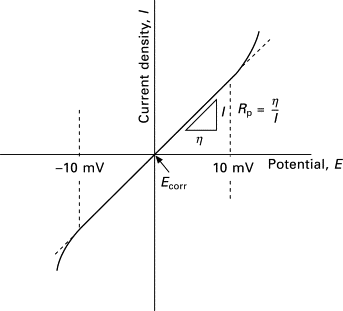

LPR Calculation Coordinates : (-750.9348498954155, 1.009269653984807e-09)
Linear Polarization Resistance [23502.1549476] (Ω·cm²)


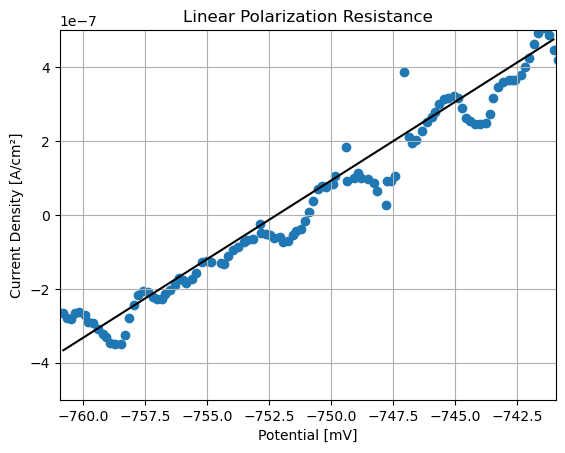

In [10]:
#Calculation of Linear Polarization Resistance

f = interp1d(V_o, Id_o, kind='linear') #Linear interpolation function

V_interpolated = np.linspace(V_o[0], V_o[-1], num=(len(V_o)*10))  #Generate 10 interpolated points per each potential row
Id_interpolated = f(V_interpolated)                               #Calculate 10 points for current

Min_distance = np.argmin(np.abs(Id_interpolated - 0))           #Find min distance from point "current = 0 A/cm2"
V_closest = V_interpolated[Min_distance]                        #Potential coordinate of the point
Id_closest = Id_interpolated[Min_distance]                      #Current coordinate of the point
print ("LPR Calculation Coordinates :", (V_closest,Id_closest)) #Print special point 

LPR_coordinate = np.arange(V_closest - 10, V_closest + 10) #Coordinates for LPR calculation: +/- 10 mV from special point 
LPR_interval = df[(df['Potential (mV) original'] >= V_closest - 10) & (df['Potential (mV) original'] <= V_closest + 10)] #Interval for LPR calculation 

x = LPR_interval[['Potential (mV) original']] #Definition of x values
y = LPR_interval['Current Density original']  #Definition of y values

linear_regression = LinearRegression()        #Linear regression function
linear_regression.fit(x, y)                   #Linear regression of specified x and y values

slope = 1000*linear_regression.coef_                                   #Slope of linear regression line
LPR = 1/(1000*linear_regression.coef_)                                 #LPR is inverse of slope of linear regression line
print("Linear Polarization Resistance", LPR, "(\u03A9\u00B7cm\u00B2)") #Print LPR and unit of measure

plt.scatter(V_o, Id_o)                               #Plot of experimental data
plt.plot(x, linear_regression.predict(x), color='0') #Plot of linear regression line
plt.xlim(V_closest - 10, V_closest + 10)             #Specifying interval on X axis
plt.ylim(-0.0000005, 0.0000005)                      #Specifying interval on Y axis
plt.xlabel('Potential [mV]')                         #X axis lable
plt.ylabel('Current Density [A/cm\u00B2]')           #Y axis lable
plt.title('Linear Polarization Resistance')          #Plot title
plt.grid(True)                                       #Enable plot grid

plt.savefig('G:\Il mio Drive\Dottorato\Python\LSV\Test_LPR', dpi=600) #Save plot as image

### Data cleaning and manipulation

Sometimes current density values from the potentiostat contains noise, due to fluctuations in corrosion reaction, and deviations due to misreadings or due to localized corrosion phenomena. For the purpose of evaluating generalized corrosion data need to be cleaned and smoothened. 

As a consequence, the following procedure of outliers removal and moving average calculation is employed. In particular, when the difference between two consecutive points in the Current Density dataframe is grater than 65% of the first value, then the second value is dropped. Moreover, the rolling average between 10 consecutive point is applied to smoothen the data.

It is crucial to carefully adjust governing parameters (Percentage_outliers and Points_moving_avg) in order not to introduce artifacts in the manipulated dataframes. In fact, 65% and 10 points are chosen for this specific sample but are subjected to modification in case of other samples are analysed, for this purpose these parameters are highlighted and easy to be accessed.

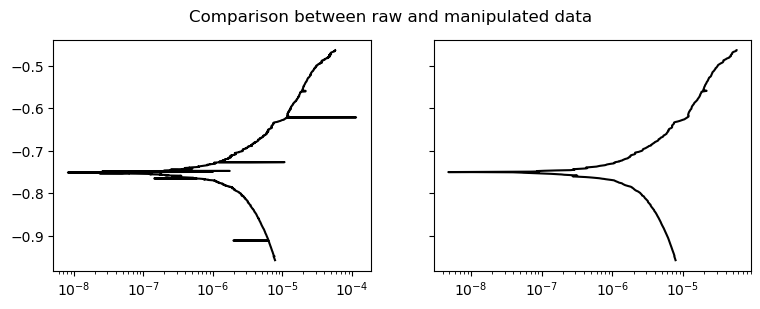

In [11]:
#Outlier removal
Percentage_outliers = 65

outlier_indices = [] #Create an empty list to store the indices of the outliers
for i in range(len(df['Current Density manipulated']) - 1): #Iterate over the rows of the 'Current Density' dataframe except for last row
    if np.abs(df['Current Density manipulated'].iloc[i+1] - df['Current Density manipulated'].iloc[i]) > (Percentage_outliers/100) * np.abs(df['Current Density manipulated'].iloc[i]): #Check if the difference between the current value and the following value exceeds a certain percentage of the prior value
        outlier_indices.append(i+1) 
df.drop(outlier_indices, inplace=True) #Drop the rows corresponding to the outlier

#Moving average
Points_moving_avg = 10
df['Current Density moving average'] = df['Current Density manipulated'].rolling(window = Points_moving_avg, min_periods = Points_moving_avg).mean() #Moving average of current density data
df['Current Density moving average'].iloc[:Points_moving_avg] = df['Current Density manipulated'].iloc[:Points_moving_avg] #Substituition of first points of moving average data set

#Absolute value
df['Current Density (Abs) moving average'] = np.abs(df['Current Density moving average']) #Absolute value of obtained moving average of current density

#Dataframe naming
V          = df['Potential (mV) manipulated'].values    #Potential in mV
Vv         = df['Potential manipulated'].values         #Potential in V
I          = df['Current manipulated'].values           #Current
Id         = df['Current Density manipulated'].values   #Current density
Id_avg     = df['Current Density moving average']       #Moving average of current density
Id_abs_avg = df['Current Density (Abs) moving average'] #Absolute value of moving average of current

fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)   #Creation of a panel with shared Y axis
axs[0].plot(Id_abs_o,Vv_o, color='0')                        #Plot of original data
axs[0].set_xscale('log')                                     #X axis log scale
axs[1].plot(Id_abs_avg,Vv, color='0')                        #Plot of manipulated data
axs[1].set_xscale('log')                                     #X axis log scale
fig.suptitle('Comparison between raw and manipulated data'); #Plot title

### Tafel graphical extrapolation

Tafel extrapolation is a mathematical technique used to estimate either the corrosion current (Icorr) or the corrosion potential (Ecorr) in an electrochemical cell, and by extension, the corrosion rate. Extrapolation involves extending a known sequence of linear values within a Tafel plot to determine these parameters. Tafel extrapolations can be performed either manually or by specialized computer software. 

A Tafel plot, which is a graphical relationship between the current generated in an electrochemical cell and the electrode potential, usually consists of two diverging logarithmic plot lines representing the anodic and cathodic currents.

Extrapolation is performed by extending the linear portions of the anodic and cathodic plots back to their intersection. These two lines eventually meet at a point where the corrosion current, Icorr, is obtained. The value of Icorr can then be input into specific mathematical equations to calculate parameters such as corrosion rate. Morever the slope of Tafel lines (both for the nodic branch and for the cathodic branch) can be calculated.

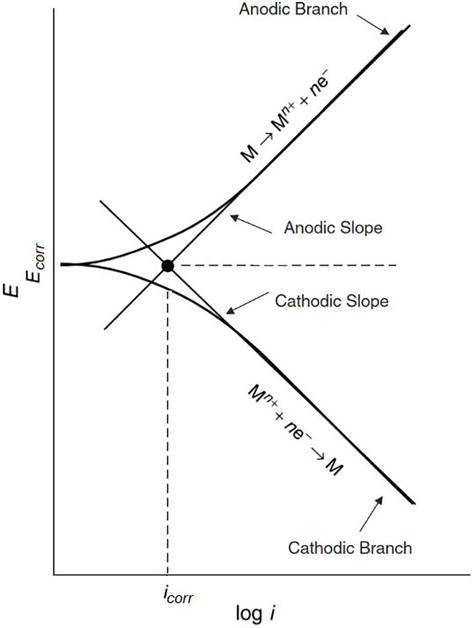

Cathodic Tafel slope (mV/decade): [-403.06048644]
Anodic Tafel slope (mV/decade): [219.99877007]
Icorr (A/cm²): [2.49682251e-06]
Ecorr (mV) [-749.95800188]
Computing time: 2.7323365211486816 seconds


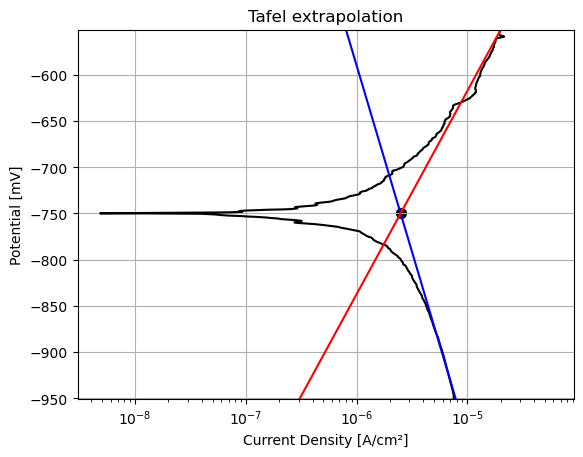

In [12]:
#Tafel extrapolation method

df['Current Density (Abs) moving average (log)'] = np.log10(df['Current Density (Abs) moving average'])
Id_abs_avg_log = df['Current Density (Abs) moving average (log)'] #Log of absolute value of moving average of current

#Cathodic branch
Cathodic_potential = df[(df['Potential (mV) manipulated'] <= V_closest)] #Filtering of original dataframe

x_c = Cathodic_potential[['Current Density (Abs) moving average (log)']] #Definition of y values
y_c = Cathodic_potential['Potential (mV) manipulated']                   #Definition of x values

linear_regression_c = LinearRegression()            #Linear regression function
linear_regression_c.fit(x_c[50:-600], y_c[50:-600]) #Linear regression of specified x and y values

inter_c = linear_regression_c.intercept_ #Intercept of linear regression line of cathodic branch
slope_c = linear_regression_c.coef_      #Slope of linear regression line of cathodic branch
print('Cathodic Tafel slope (mV/decade):',slope_c)

#Anodic branch
Anodic_potential = df[(df['Potential (mV) manipulated'] >= V_closest)] #Filtering of original dataframe

x_a = Anodic_potential[['Current Density (Abs) moving average (log)']] #Definition of y values
y_a = Anodic_potential['Potential (mV) manipulated']                   #Definition of x values

linear_regression_a = LinearRegression()              #Linear regression function
linear_regression_a.fit(x_a[500:-250], y_a[500:-250]) #Linear regression of specified x and y values
inter_a = linear_regression_a.intercept_              #Intercept of linear regression line of anodic branch
slope_a = linear_regression_a.coef_                   #Slope of linear regression line of anodic branch
print('Anodic Tafel slope (mV/decade):',slope_a)

#Corrosion conditions
icorr_tafel = (inter_c - inter_a) / (slope_a - slope_c) #Definition of fitted icorr
Ecorr_tafel = slope_a * icorr_tafel + inter_a           #Definition of fitted Ecorr
print("Icorr (A/cm\u00B2):", 10**icorr_tafel)           #Printing of fitted corrosion current density
print("Ecorr (mV)", Ecorr_tafel)                        #Printing of fitted corrosion potential

plt.plot(Id_abs_avg,V, color = 'black')                            #Plot of manipulated data
plt.plot(10**x_c, linear_regression_c.predict(x_c), color='blue')  #Plot of linear regression line of cathodic branch
plt.plot(10**x_a, linear_regression_a.predict(x_a), color='red')   #Plot of linear regression line of anodic branch
plt.scatter(10**icorr_tafel, Ecorr_tafel, s = 50, color = 'black') #Corrosion conditions
plt.xlabel('Current Density [A/cm\u00B2]')                         #Lable X axis
plt.ylim(V_closest-200, V_closest+200)                             #Limit Y axis
plt.ylabel('Potential [mV]')                                       #Lable Y axis
plt.title('Tafel extrapolation')                                   #Plot title
plt.xscale('log')                                                  #log scale X axis
plt.grid(True)                                                     #Enabled plot grid

end_time = time.time()                          #End the timer
total_time = end_time - start_time              #Elapsed time
print("Computing time:", total_time, "seconds") #Print elapsed time

plt.savefig('G:\Il mio Drive\Dottorato\Python\LSV\Test_Tafel', dpi=600) #Save plot as image